# Nospareセミナー

---
## セミナー情報

<small>2024年9月28日(土)13:00-15:00</small>  
<small>共立出版 × Nospare タイアップセミナー</small>  
[**ウイルス感染の数理モデルとシミュレーション～データを定量的に理解する～**](https://seminar.no-spare.com/product/240928)  

データ解析実習 14:00 – 14:20：常微分方程式の数値計算と非線形混合効果モデルを用いたパラメータ推定

> ウイルスダイナミクスをモデリングするために用いられる微分方程式の数値計算について、Rのパッケージを用いた実行方法を説明する。また、応用編で説明される非線形混合効果モデルについて、Rのパッケージを用いた実装方法の１例を紹介する。

担当者：岩波翔也（名古屋大学大学院理学研究科・異分野融合生物学研究室（iBLab）・講師）

---

## 準備

In [1]:
install.packages(c("ggplot2", "patchwork", "deSolve", "saemix", "dplyr"))

Installing packages into ‘/home/iwanami/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
library(patchwork)
library(deSolve)
library(saemix)
library(dplyr)

Loading required package: npde

Package saemix, version 3.3, March 2024
  please direct bugs, questions and feedback to emmanuelle.comets@inserm.fr



Attaching package: ‘saemix’


The following objects are masked from ‘package:npde’:

    kurtosis, skewness



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




---

## ウイルスダイナミクスの数理モデル

標的細胞が増殖しない場合のウイルスダイナミクスを表す数理モデル

$$
\begin{eqnarray}
\frac{d T(t)}{dt} &=& - \beta T(t) V(t) \\
\frac{d I(t)}{dt} &=& \beta T(t) V(t) - \delta I(t) \\
\frac{d V(t)}{dt} &=& p I(t) - c V(t)
\end{eqnarray}
$$

について、準定常状態近似 $c>>\delta$ を用いて

$$
\begin{eqnarray}
\frac{d f(t)}{dt} &=& - \beta f(t) V(t) \\
\frac{d V(t)}{dt} &=& \gamma f(t) V(t) - \delta V(t)
\end{eqnarray}
$$

と表される常微分方程式を考える。

ここで、

- $T(t)$：時刻 $t$ における標的細胞数
- $I(t)$：時刻 $t$ における感染細胞数
- $V(t)$：時刻 $t$ におけるウイルス粒子数
- $\beta$：感染率
- $\delta$：感染細胞の排除率
- $p$：感染細胞あたりのウイルス粒子産生数
- $c$：ウイルス粒子の排除率
- $f(t) = T(t)/T(0)$
- $\gamma = p \beta / c$

である。

---
## 常微分方程式の数値計算


参照：https://github.com/NU-iBLab/Book-VirusDynamics  
> コード2-4：非線形常微分方程式の数値計算の実装  

非線形常微分方程式は一般的に厳密に解くことができない（解ける場合もある）。  
→ 近似的に解く。

- 線形化
- コンピュータを用いた**数値計算**  
など

数値計算で

$$
\begin{eqnarray}
\frac{d y(t)}{dt} &=& f(t, y(t)) \\
y(t_0) &=& y_0
\end{eqnarray}
$$

を解くことを考える。

<オイラー法>

$$
\begin{eqnarray}
y_{n+1} &=& y_n + hf(t_n, y_n) \\
t_{n+1} &=& t_n + h
\end{eqnarray}
$$

<ルンゲ=クッタ法（4次の公式）>

$$
\begin{eqnarray}
y_{n+1} &=& y_n + \frac{h}{6} \left( k_1 + 2 k_2 + 2 k_3 + k_4 \right) \\
t_{n+1} &=& t_n + h \\
k_1 &=& f(t_n, y_n) \\
k_2 &=& f \left( t_n + \frac{h}{2}, y_n + \frac{h}{2} k_1 \right) \\
k_3 &=& f \left( t_n + \frac{h}{2}, y_n + \frac{h}{2} k_2 \right) \\
k_4 &=& f \left( t_n + h, y_n + h k_3 \right)
\end{eqnarray}
$$

オイラー法でのウイルスダイナミクスの式

In [3]:
## オイラー法
## t_nでの微分を返す関数
derivs_euler <- function(t, y, pars) {
    ## t: t, y: f(t), V(t), pars: beta, gamma, delta
    
    var_f <- as.numeric(y[1])
    var_V <- as.numeric(y[2])

    par_beta <- as.numeric(pars[1])
    par_gamma <- as.numeric(pars[2])
    par_delta <- as.numeric(pars[3])
    
    vardot_f <- - par_beta*var_f*var_V
    vardot_V <- par_gamma*var_f*var_V - par_delta*var_V

    return(c(vardot_f, vardot_V))
}

In [4]:
## 計算する時間
step_size <- 0.01 # 時刻 t の刻み幅 h
stime <- seq(0, 30, by = step_size)

print(stime[1:10])
print(stime[(length(stime) - 10):length(stime)])

 [1] 0.00 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09
 [1] 29.90 29.91 29.92 29.93 29.94 29.95 29.96 29.97 29.98 29.99 30.00


モデルの初期値として $t_0 = 0, f(0) = 1, V(0) = 3.0 \times 10^4$、パラメータとして $\beta = 8.0 \times 10^{-6}, \gamma = 3.0, \delta = 0.70$ を考える。

In [5]:
## 初期値, f(0), V(0)
var_init <- c(f = 1, V = 3e+4)

## モデルパラメータ
pars <- c(beta = 8e-6, gamma = 3.0, delta = 0.7)

In [6]:
out <- c(stime[1], as.numeric(var_init))
var_n <- var_init

## オイラー法の繰り返し計算
for (i in 1:(length(stime) - 1)) {

    var_n1 <- var_n + step_size*derivs_euler(stime[i], var_n, pars)

    out <- rbind(out, c(stime[i + 1], as.numeric(var_n1)))
    var_n <- var_n1
}

colnames(out) <- c("time", names(var_init))
rownames(out) <- NULL
out <- as.data.frame(out)

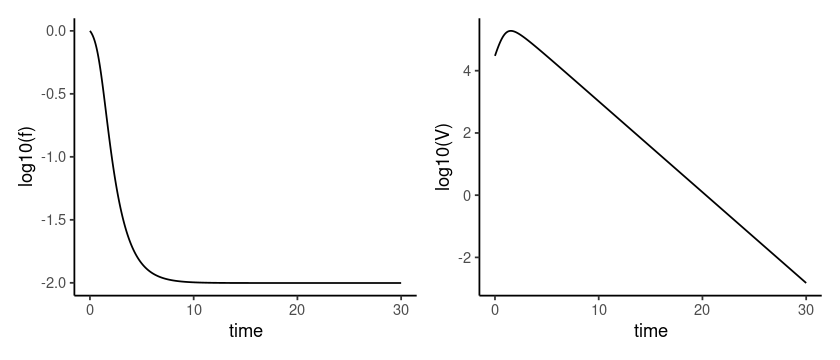

In [7]:
## 計算結果のプロット

plt_f <- ggplot(data = out, aes(x = time, y = log10(f))) +
    geom_line() +
    theme_classic() +
    theme()

plt_V <- ggplot(data = out, aes(x = time, y = log10(V))) +
    geom_line() +
    theme_classic() +
    theme()

options(repr.plot.width=7, repr.plot.height=3)
plt_f + plt_V

## Rのパッケージを用いた常微分方程式の数値計算の実装

科学計算に用いられるプログラミング言語の場合は、常微分方程式を数値的に解くためのパッケージ（ソルバー）が開発されていることが多い。

ここでは `deSolve` パッケージの `ode` 関数を用いて計算する。

https://www.rdocumentation.org/packages/deSolve/versions/1.40/topics/ode

In [8]:
## ode用に微分を返す関数
ode_derivs <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        ## var: T(t), V(t)

        var_f <- var[1]
        var_V <- var[2]
        
        vardot_f <- - beta * var_f * var_V
        vardot_V <- gamma * var_f * var_V - delta * var_V
        
        return(list(c(vardot_f, vardot_V)))
    })
}

In [9]:
## 初期値 var とパラメータ pars を受け取って常微分方程式の数値計算結果を返す関数
ODEs <- function(var, pars) {

    names(pars) <- c("beta", "gamma", "delta")
    
    ## 計算のタイムステップ
    t_list <- seq(0, 30, by = step_size)
    ## 初期値 f(0), V(0)
    var_init <- var
    ## 微分方程式の計算, ここではルンゲ=クッタ法（4次の公式）を指定してみる
    out <- ode(y = var_init, # 初期値
               times = t_list, # 時刻
               func = ode_derivs, # 微分
               parms = pars, # パラメータ
               method = "rk4") # 数値計算の方法
    
    as.data.frame(out)
}

In [10]:
## 初期値, f(0), V(0)
var_init <- c(f = 1, V = 3e+4)

## モデルパラメータ
pars <- c(beta = 8e-6, gamma = 3.0, delta = 0.7)

In [11]:
out <- ODEs(var_init, pars)

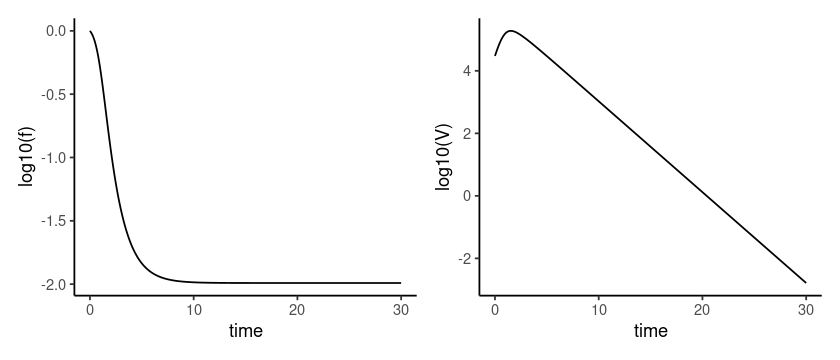

In [12]:
## 計算結果のプロット

plt_f <- ggplot(data = out, aes(x = time, y = log10(f))) +
    geom_line() +
    theme_classic() +
    theme()

plt_V <- ggplot(data = out, aes(x = time, y = log10(V))) +
    geom_line() +
    theme_classic() +
    theme()

options(repr.plot.width = 7, repr.plot.height = 3)
plt_f + plt_V

---

## 非線形混合効果モデル


応用編再掲

説明変数と目的変数の関係が非線形の関係が $f$ で与えられるとする：

$$
\begin{eqnarray}
y_{ij} &=& f(x_{ij}, q_i) + \varepsilon_{ij}\\
i &=& 1,...,M \\
j &=& 1,...,n_i
\end{eqnarray}
$$

ここで

- $M$：被験者数
- $n_i$：被験者 $i$ に対する観測回数
- $x_{ij}$：実数を値にもつ説明変数
- $q_i$：被験者 $i$ がもつ固有のパラメータ
- $f$：$x_{ij}$ と $q_i$ の関数
- $\varepsilon_{ij}$：被験者 $i$ の $j$ 番目の観測値の誤差を表す確率変数

$$
q_i = \boldsymbol{A}_i \boldsymbol{\beta} + \boldsymbol{B}_i \eta_i
$$

- $\boldsymbol{\beta}$：固定効果を表す係数ベクトル
- $\eta_i$：被験者 $i$ がもつ固有の変量効果
- $\boldsymbol{A}_i$：被験者 $i$ がもつ固有の固定効果の計画行列
- $\boldsymbol{B}_i$：被験者 $i$ がもつ固有の変量効果の計画行列


## Rのパッケージを用いた非線形混合効果モデルでのパラメータ推定の実装


非線形混合効果モデルの実装のためのソフトウェア
- Monolix (https://lixoft.com/products/monolix/)  
  - 学術期間や非営利団体などの非営利利用は無料  
  - 商用利用は有料
- https://www.page-meeting.org/default.asp?alias=912

ここではオープンソースかつSAEMアルゴリズムが実装された `saemix` パッケージを用いて実装する。

- https://saemixr.github.io/
- https://www.rdocumentation.org/packages/saemix

### 擬似データの生成

ここで用いる擬似データの生成手順は以下の通り：

1. 100人分のパラメータセットの生成
1. 100人分の発症からのウイルス量の変化の計算
1. 1日目から14日目までのうちランダムに5日取得

In [13]:
## 100人分のパラメータセット

set.seed(1)

## ここでは beta, gamma, delta を推定することを考える。
## 対数正規分布からサンプリング

pars_sim_set <- data.frame(beta = rlnorm(100, log(7.9e-6), 0.16),
                           gamma = rlnorm(100, log(3.8), 0.27),
                           delta = rlnorm(100, log(0.68), 0.56))

In [14]:
## ウイルスダイナミクスの数理モデルを計算するための関数

## C言語による高速化
## https://cran.r-project.org/web/packages/deSolve/vignettes/compiledCode.pdf
## virus.cが実行ディレクトリにある必要がある。
system("R CMD SHLIB virus.c")  
dyn.load( paste("virus",.Platform$dynlib.ext,sep="") ) 

## 初期値とパラメータを受け取って常微分方程式の数値計算結果を返す関数
ODEs <- function(var, pars) {

    names(pars) <- c("beta", "gamma", "delta")
    
    ## 計算のタイムステップ
    t_list <- stime
    ## 初期値 f(0), V(0)
    var_init <- var
    ## 微分方程式の計算, ここではルンゲ=クッタ法（4次の公式）を指定してみる
    out <- ode(y = var_init, times = t_list, func = "derivs", parms = pars, method = "rk4",
               initfunc = "initparms", nout = 1, outnames = "", dllname = "virus")
    
    as.data.frame(out)
}

In [15]:
## 計算する時間
step_size <- 0.01
stime <- seq(0, 30, by = step_size)

## 1日ごとの時間のインデックス
time_measurement <- seq(1, 14, by = 1)
vec_measurement <- c()
for (i in 1:length(time_measurement)) {
    vec_measurement <- c(vec_measurement,
                         which(abs(stime - time_measurement[i]) == min(abs(stime - time_measurement[i]))))
}

In [16]:
set.seed(20)

out <- data.frame()

for (i in 1:nrow(pars_sim_set)) {
    pars_temp <- unlist(pars_sim_set[i, ])
    
    var_init <- c(f = 1, V = 3e+4)

    out_temp <- ODEs(var_init, pars_temp)[sample(vec_measurement, 5, replace = FALSE), ]
    out_temp$V_log <- log10(out_temp$V) + rnorm(length(out_temp$V), 0, 0.3)
    out_temp$id <- paste0("ID_", i)
    
    out <- rbind(out, out_temp)
}

## 検出限界（100 copies/mL）を設定
out <- mutate(out, V_log = ifelse(V_log > 2, V_log, 2))

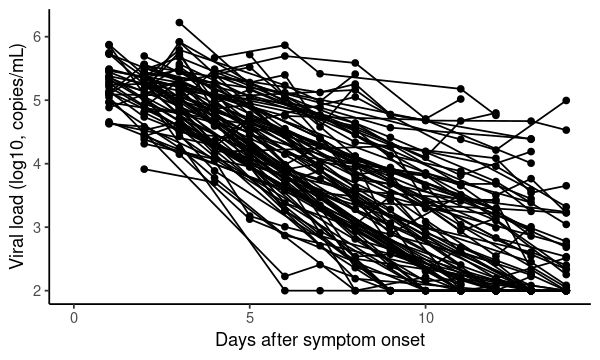

In [17]:
## 生成されたデータのプロット
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = out, aes(x = time, y = V_log, group = id)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    xlab("Days after symptom onset") +
    ylab("Viral load (log10, copies/mL)") +
    theme_classic()

## 非線形混合効果モデルでのパラメータ推定の実装

In [18]:
## データの整形

## 検出限界100 copies/mLより大きいの観測値が2点以下の患者を除外

ids_remove <- c()

for (i in 1:length(unique(out$id))) {
    if (nrow(subset(out, id == unique(out$id)[i] & V_log > 2)) < 3) {
        ids_remove <- c(ids_remove, unique(out$id)[i])
    }
}

print(ids_remove)

data_viralload <- subset(out, !(id %in% ids_remove))

## 検出限界のデータを示すcens列の定義
data_viralload <- mutate(data_viralload, cens = ifelse(V_log > 2, 0, 1))

## 常微分方程式の数値計算の時の時刻の場所の定義
vec_time <- c()
for (i in 1:nrow(data_viralload)) {
    vec_time <- c(vec_time, which(abs(stime - data_viralload$time[i]) == min(abs(stime - data_viralload$time[i]))))
}
data_viralload$time_id <- vec_time

 [1] "ID_6"  "ID_8"  "ID_15" "ID_42" "ID_45" "ID_50" "ID_55" "ID_61" "ID_64"
[10] "ID_74" "ID_88" "ID_97"


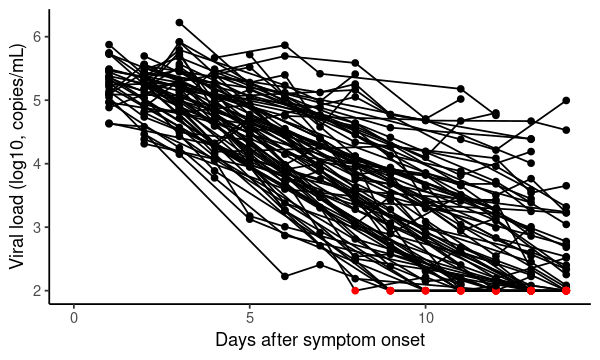

In [19]:
## 推定に用いるデータのプロット
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = data_viralload, aes(x = time, y = V_log, group = id)) +
    geom_line() +
    geom_point(aes(color = factor(cens, levels = c(0, 1)))) +
    scale_color_manual(values = c(`0` = "black", `1` = "red")) +
    scale_x_continuous(limits = c(0, NA)) +
    xlab("Days after symptom onset") +
    ylab("Viral load (log10, copies/mL)") +
    theme_classic() +
    theme(legend.position = "none")

In [20]:
## データの定義
## https://www.rdocumentation.org/packages/saemix/versions/3.3/topics/saemixData

saemix.data <- saemixData(name.data = data_viralload,
                          header = TRUE,
                          name.group = c("id"), # 患者のID
                          name.predictors = c("time_id"), # 説明変数
                          name.response = c("V_log"), # 目的変数
                          name.cens = c("cens")) # 検出限界



The following SaemixData object was successfully created:

Object of class SaemixData
    longitudinal data for use with the SAEM algorithm
Dataset data_viralload 
    Structured data: V_log ~ time_id | id 
    Predictor: time_id () 


連続変数に対する観測誤差モデルとして、時刻（説明変数, $t_{ij}$）に対するウイルス量（目的変数, $y_{ij}$）の関係を定義する。

$$
y_{ij} = f(t_{ij}, \psi_i) + g(t_{ij},\psi_i,\xi) \varepsilon_{ij}
$$

ここで、

- $i$：個体を表すインデックス
- $j$ は観測を表すインデックス
- $\psi_i$：個体 $i$ のindividual parameter
- $f(t_{ij}, \psi_i)$：$y_{ij}$ の条件付期待値
- $g(t_{ij},\psi_i,\xi)$：追加のパラメータ $\xi$ を用いた $y_{ij}$ の標準偏差
- $\varepsilon_{ij}$：標準正規分布に従う残差

である。

ここではウイルスダイナミクスの数理モデル

$$
\begin{eqnarray}
\frac{d f(t)}{dt} &=& - \beta f(t) V(t) \\
\frac{d V(t)}{dt} &=& \gamma f(t) V(t) - \delta V(t)
\end{eqnarray}
$$

から $f(t_{ij}, \psi_i) = V(t_{ij}, \beta_i, \gamma_i, \delta_i)$ を定義する。

実際には、

$$
\log_{10}{(y_{ij})} = \log_{10}{(f(t_{ij}, \psi_i))} + g(t_{ij},\psi_i,\xi) \varepsilon_{ij}
$$

としてモデルとデータを変換していることに注意する。

In [21]:
## 非線形なモデルの定義
## psi_i, i, t_ij に対して V(t_ij, psi_i) を返す関数

model_saemix <- function(psi, id, xidep) {
    # psi: a matrix of individual parameters
    # id: a vector of indices specifying which records belong to a given individual
    # xidep: a matrix of dependent variables
    
    ypred <- c()
    tim <- xidep[, 1]

    var_init <- c(f = 1, V = 3e+4)

    if (length(unique(id)) > 1) {
        list_time <- split(tim, id)
        mat_pars <- as.data.frame(t(psi[as.numeric(names(list_time)), ]))
        
        ypred <- as.vector(
            mapply(function(pars, vec_time){
                        if (is.list(pars)) {pars <- unlist(pars)}
                        if (length(pars) == 1) {print(list_time)}
                        if (is.list(vec_time)) {vec_time <- unlist(vec_time)}
                
                        log10(ODEs(var_init, pars)$V[as.numeric(vec_time)])
                    },
                    mat_pars,
                    list_time)
        
        )
    } else {
        ypred <- log10(ODEs(var_init, psi[1,])$V[tim])
    }

    # return a vector of predicted values
    return(ypred)
}

上記の条件付期待値を表すモデルが与えられるときの観測誤差モデル（$g(t_{ij},\psi_i,\xi)$）とindividual parameterが従うモデルを定義する。

ここでは

$$
g(t_{ij},\psi_i,\xi) = a
$$

として、標準偏差が定数である場合を考える。

また、

$$
\log{(\psi_i)} = \log{(\psi_{pop})} + \eta_i
$$

として、標準正規分布に従う確率変数 $\eta_i \sim \mathcal{N}(0, \omega^2)$ を用いて $\psi_i$ が $\psi_{pop}$ の周りで対数正規分布することを考える。

In [22]:
## 非線形混合効果モデルの定義
## https://www.rdocumentation.org/packages/saemix/versions/3.3/topics/saemixModel

saemix.model <- saemixModel(model = model_saemix, # V(t_ij, psi_i) を返す関数
                            description = "Virus dynamics",
                            psi0 = matrix(c(7.9e-6, 3.5, 0.7), ncol = 3, dimnames = list(NULL, c("beta", "gamma", "delta"))), # population parameterの推定初期値
                            error.model = "constant", # 誤差モデル
                            error.init = c(1, 1), # 誤差モデルのパラメータ、ここでは a、constantの場合2つ目は無視
                            transform.par = c(1, 1, 1), # パラメータの分布：1=対数正規分布
                            omega.init = matrix(c(1, 0, 0, 0, 1, 0, 0, 0, 1), ncol = 3, byrow = TRUE), # パラメータの分散共分散行列の推定初期値
                            covariance.model = matrix(c(1, 0, 0, 0, 1, 0, 0, 0, 1), ncol = 3, byrow = TRUE)) # パラメータの分散共分散行列のモデル



The following SaemixModel object was successfully created:

Nonlinear mixed-effects model
  Model function:  Virus dynamics
  Model type:  structural
function(psi, id, xidep) {
    # psi: a matrix of individual parameters
    # id: a vector of indices specifying which records belong to a given individual
    # xidep: a matrix of dependent variables
    
    ypred <- c()
    tim <- xidep[, 1]

    var_init <- c(f = 1, V = 3e+4)

    if (length(unique(id)) > 1) {
        list_time <- split(tim, id)
        mat_pars <- as.data.frame(t(psi[as.numeric(names(list_time)), ]))
        
        ypred <- as.vector(
            mapply(function(pars, vec_time){
                        if (is.list(pars)) {pars <- unlist(pars)}
                        if (length(pars) == 1) {print(list_time)}
                        if (is.list(vec_time)) {vec_time <- unlist(vec_time)}
                
                        log10(ODEs(var_init, pars)$V[as.numeric(vec_time)])
                    },
              

SAEMアルゴリズムを用いてpopulation parameterを推定する。

参考：
https://wiki.inria.fr/popix/The_SAEM_algorithm_for_estimating_population_parameters

`saemix` 関数はpopulation parameterの推定に加えて

- **individual paraemterの推定**
- population parameterの推定量の標準誤差と線形化を用いた対数尤度の推定
- 重点サンプリング（importance sampling）による対数尤度の推定

を行う。

ここでは推定されたindividual parameterの値を用いてデータとの適合を視覚的に確認する。

In [23]:
# Run SAEM
# https://www.rdocumentation.org/packages/saemix/versions/3.3/topics/saemix
# https://www.rdocumentation.org/packages/saemix/versions/3.3/topics/saemixControl

time_start <- Sys.time()
print(time_start)

options(repr.plot.width = 7, repr.plot.height = 7)

options_saemix <- list(seed = 39546, # 乱数のシード
                       nbiter.saemix = c(100, 30), # SAEMアルゴリズムの反復回数、default: c(300, 100)
                       nmc.is = 50, #default: 5000
                       save.graphs = FALSE)

fit <- saemix(saemix.model, saemix.data, options_saemix)

time_end <- Sys.time()

print(time_end - time_start)

[1] "2024-09-21 19:17:07 JST"
Nonlinear mixed-effects model fit by the SAEM algorithm
-----------------------------------
----          Data             ----
-----------------------------------
Object of class SaemixData
    longitudinal data for use with the SAEM algorithm
Dataset data_viralload 
    Structured data: V_log ~ time_id | id 
    Predictor: time_id () 
Dataset characteristics:
    number of subjects:     88 
    number of observations: 440 
    average/min/max nb obs: 5.00  /  5  /  5 
First 10 lines of data:
         id time_id    V_log mdv cens occ ytype
201    ID_1     201 4.384237   0    0   1     1
601    ID_1     601 3.599413   0    0   1     1
801    ID_1     801 3.484331   0    0   1     1
901    ID_1     901 2.708952   0    0   1     1
1101   ID_1    1101 2.147631   0    0   1     1
2015  ID_10     201 4.935661   0    0   1     1
5013  ID_10     501 4.497417   0    0   1     1
7012  ID_10     701 3.470826   0    0   1     1
11012 ID_10    1101 2.000000   0    1  

In [24]:
## 推定したindividual parametersの読み込み

## 本来はここ
# est_indiv_pars <- read.csv("newdir/indiv_parameters.txt", sep = " ", row.names = 1)

## セミナーでは時間がかかるので過去に推定したファイルを使用
est_indiv_pars <- read.csv("forseminar/indiv_parameters.txt", sep = " ", row.names = 1)

In [25]:
## individual parametersを用いてデータとモデルのプロット

var_init <- c(f = 1, V = 3e+4)
plt <- list()

for (i in 1:nrow(est_indiv_pars)) {

    pars_temp <- unlist(est_indiv_pars[i,])
    out_temp <- ODEs(var_init, pars_temp)
    data_temp <- subset(data_viralload, id == rownames(est_indiv_pars)[i])
    
    plt[[i]] <- ggplot() +
        geom_hline(yintercept = 2, linetype = "dashed", color = "grey") +
        geom_line(data = out_temp, aes(x = time, y = log10(V))) +
        geom_point(data = data_temp, aes(x = time, y = V_log, color = factor(cens, levels = c(0, 1)))) +
        scale_color_manual(values = c(`0` = "black", `1` = "red")) +
        scale_y_continuous(limits = c(0, 8)) +
        xlab("Days after symptom onset") +
        ylab("Viral load (log10, copies/mL)") +
        labs(title = rownames(est_indiv_pars)[i]) +
        theme_classic() +
        theme(plot.title = element_text(hjust = 0.5),
              legend.position = "none")
    
}

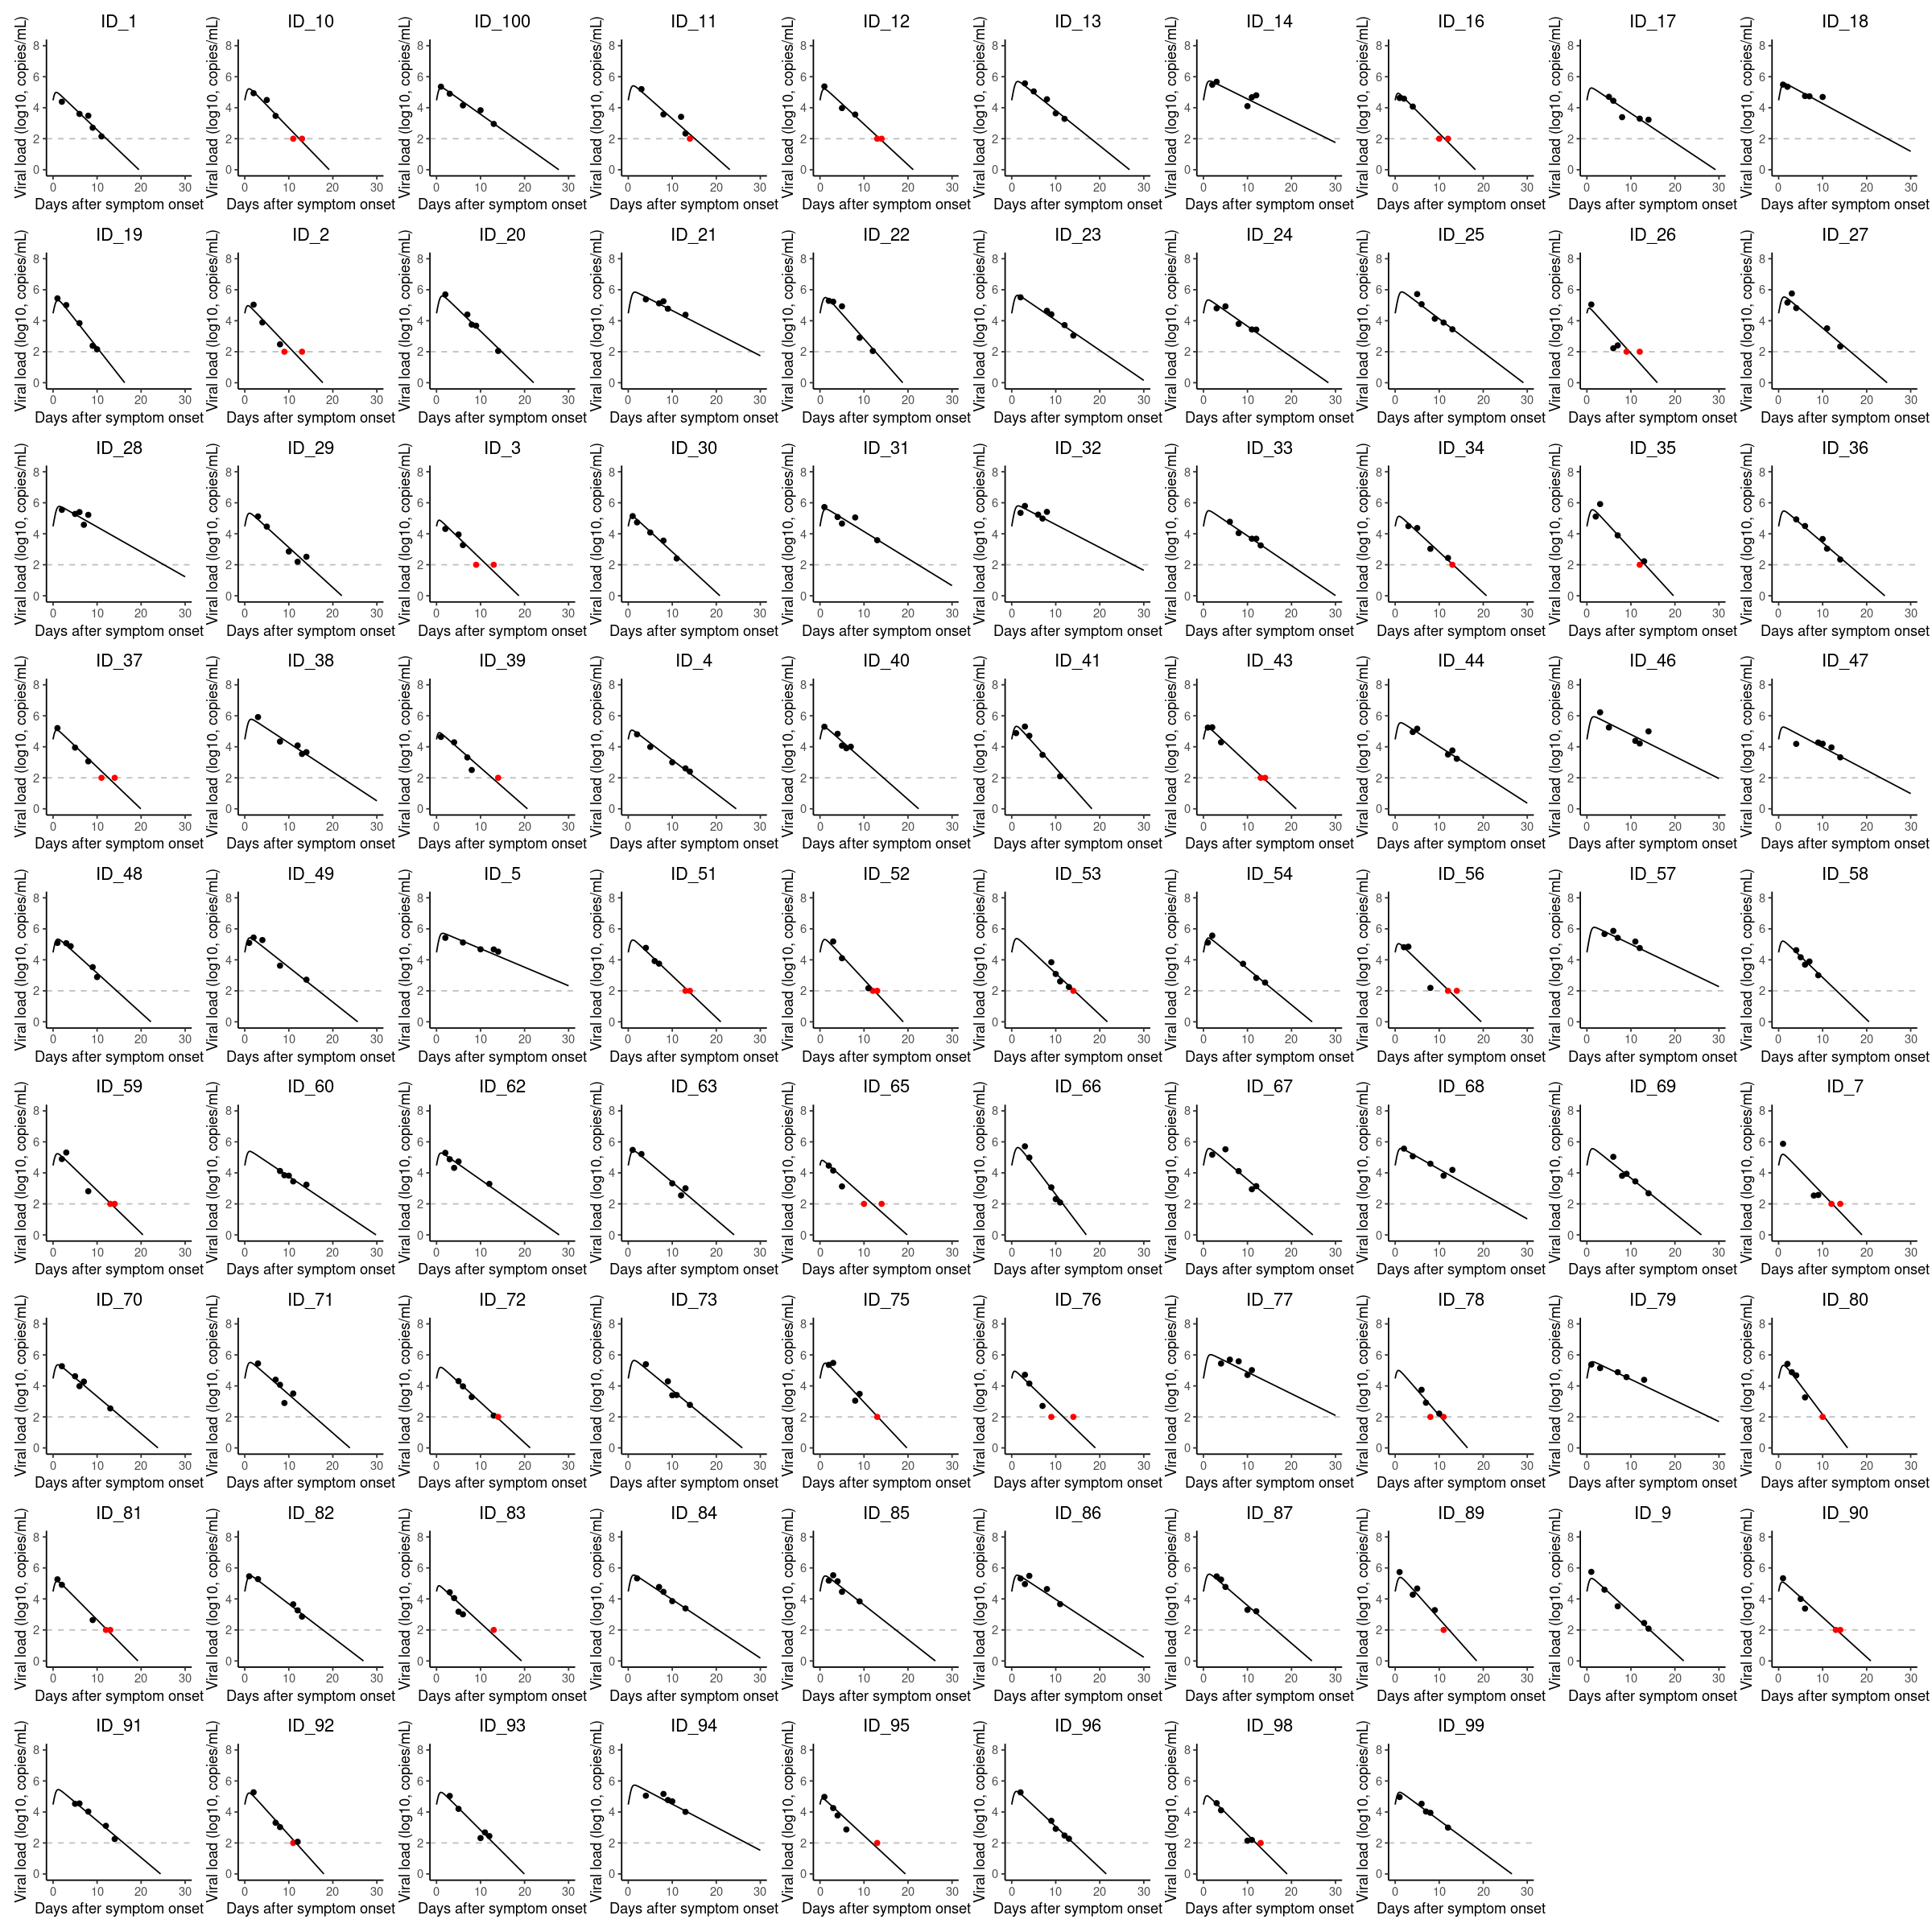

In [26]:
## individual parametersを用いてデータとモデルのプロットの表示
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
wrap_plots(plt)
options(warn = 0)

## 問い合わせ

本コードに関する問い合わせは https://iwanami.me まで